In [1]:
import math
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from numba import jit
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import notebook
import seaborn as sns
from matplotlib.colors import ListedColormap
import itertools

In [2]:
## FAST NUMBA PROCESSING FUNCTIONS
@jit(nopython=True)
def fast_standardize(data):
    a_ = (data - np.mean(data)) / np.std(data)
    return a_


def fast_nchoose2(n, k):
    a = np.ones((k, n - k + 1), dtype=int)
    a[0] = np.arange(n - k + 1)
    for j in range(1, k):
        reps = (n - k + j) - a[j - 1]
        a = np.repeat(a, reps, axis=1)
        ind = np.add.accumulate(reps)
        a[j, ind[:-1]] = 1 - reps[1:]
        a[j, 0] = j
        a[j] = np.add.accumulate(a[j])
        return a


@jit(nopython=True)
def fast_running_mean(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N % 2 == 0:
            a, b = i - (N - 1) // 2, i + (N - 1) // 2 + 2
        else:
            a, b = i - (N - 1) // 2, i + (N - 1) // 2 + 1
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out


@jit(nopython=True)
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result


@jit(nopython=True)
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)


@jit(nopython=True)
def np_std(array, axis):
    return np_apply_along_axis(np.std, axis, array)


@jit(nopython=True)
def angle_between(vector1, vector2):
    """ Returns the angle in radians between given vectors"""
    v1_u = unit_vector(vector1)
    v2_u = unit_vector(vector2)
    minor = np.linalg.det(
        np.stack((v1_u[-2:], v2_u[-2:]))
    )
    if minor == 0:
        sign = 1
    else:
        sign = -np.sign(minor)
    dot_p = np.dot(v1_u, v2_u)
    dot_p = min(max(dot_p, -1.0), 1.0)
    return sign * np.arccos(dot_p)


@jit(nopython=True)
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


@jit(nopython=True)
def fast_displacment(data, reduce=False):
    data_length = data.shape[0]
    if reduce:
        displacement_array = np.zeros((data_length, int(data.shape[1] / 10)), dtype=np.float64)
    else:
        displacement_array = np.zeros((data_length, int(data.shape[1] / 2)), dtype=np.float64)
    for r in range(data_length):
        if r < data_length - 1:
            if reduce:
                count = 0
                for c in range(int(data.shape[1] / 2 - 2), data.shape[1], int(data.shape[1] / 2)):
                    displacement_array[r, count] = np.linalg.norm(data[r + 1, c:c + 2] - data[r, c:c + 2])
                    count += 1
            else:
                for c in range(0, data.shape[1], 2):
                    displacement_array[r, int(c / 2)] = np.linalg.norm(data[r + 1, c:c + 2] - data[r, c:c + 2])
    return displacement_array


@jit(nopython=True)
def fast_length_angle(data, index):
    data_length = data.shape[0]
    length_2d_array = np.zeros((data_length, index.shape[1], 2), dtype=np.float64)
    for r in range(data_length):
        for i in range(index.shape[1]):
            ref = index[0, i]
            target = index[1, i]
            length_2d_array[r, i, :] = data[r, ref:ref + 2] - data[r, target:target + 2]
    length_array = np.zeros((data_length, length_2d_array.shape[1]), dtype=np.float64)
    angle_array = np.zeros((data_length, length_2d_array.shape[1]), dtype=np.float64)
    for k in range(length_2d_array.shape[1]):
        for kk in range(data_length):
            length_array[kk, k] = np.linalg.norm(length_2d_array[kk, k, :])
            if kk < data_length - 1:
                try:
                    angle_array[kk, k] = np.rad2deg(
                        angle_between(length_2d_array[kk, k, :], length_2d_array[kk + 1, k, :]))
                except:
                    pass
    return length_array, angle_array


@jit(nopython=True)
def fast_smooth(data, n):
    data_boxcar_avg = np.zeros((data.shape[0], data.shape[1]))
    for body_part in range(data.shape[1]):
        data_boxcar_avg[:, body_part] = fast_running_mean(data[:, body_part], n)
    return data_boxcar_avg


@jit(nopython=True)
def fast_feature_extraction(data, framerate, index, smooth):
    window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
    features = []
    for n in range(len(data)):
        displacement_raw = fast_displacment(data[n])
        length_raw, angle_raw = fast_length_angle(data[n], index)
        if smooth:
            displacement_run_mean = fast_smooth(displacement_raw, window)
            length_run_mean = fast_smooth(length_raw, window)
            angle_run_mean = fast_smooth(angle_raw, window)
            features.append(np.hstack((length_run_mean[1:, :], angle_run_mean[:-1, :], displacement_run_mean[:-1, :])))
        else:
            features.append(np.hstack((length_raw[1:, :], angle_raw[:-1, :], displacement_raw[:-1, :])))
    return features


@jit(nopython=True)
def fast_feature_binning(features, framerate, index):
    binned_features_list = []
    for n in range(len(features)):
        bin_width = int(framerate / 10)
        for s in range(bin_width):
            binned_features = np.zeros((int(features[n].shape[0] / bin_width), features[n].shape[1]), dtype=np.float64)
            for b in range(bin_width + s, features[n].shape[0], bin_width):
                binned_features[int(b / bin_width - 1), 0:index.shape[1]] = np_mean(features[n][(b - bin_width):b,
                                                                                    0:index.shape[1]], 0)
                binned_features[int(b / bin_width - 1), index.shape[1]:] = np.sum(features[n][(b - bin_width):b,
                                                                                  index.shape[1]:], axis=0)
            binned_features_list.append(binned_features)
    return binned_features_list


def bsoid_extract_numba(data, fps):
    smooth = False
    index = fast_nchoose2(int(data[0].shape[1] / 2), 2)
    features = fast_feature_extraction(data, fps, index * 2, smooth)
    binned_features = fast_feature_binning(features, fps, index * 2)
    return binned_features


def feature_extraction(train_datalist, num_train, framerate=60):
    f_integrated = []
    for i in notebook.tqdm(range(num_train)):
        binned_features = bsoid_extract_numba([train_datalist[i]], framerate)
        f_integrated.append(binned_features[0])  # getting only the non-shifted
    features = np.vstack([f_integrated[m] for m in range(len(f_integrated))])
    scaler = StandardScaler()
    scaler.fit(features)
    scaled_features = scaler.transform(features)
    return features, scaled_features


def unison_shuffled_copies(a, b, s):
    assert len(a) == len(b)
    np.random.seed(s)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg


def feature_extraction_3d(train_datalist, framerate=60):
    window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
    f = []
    for n in range(len(train_datalist)):
        data_n_len = len(train_datalist[n])
        dxy_list = []
        disp_list = []
        for r in range(data_n_len):
            if r < data_n_len - 1:
                disp = []
                for c in range(0, train_datalist[n].shape[1], 3):
                    disp.append(
                        np.linalg.norm(train_datalist[n][r + 1, c:c + 3] -
                                       train_datalist[n][r, c:c + 3]))
                disp_list.append(disp)
            dxy = []
            for i, j in itertools.combinations(range(0, train_datalist[n].shape[1], 3), 2):
                dxy.append(train_datalist[n][r, i:i + 3] -
                           train_datalist[n][r, j:j + 3])
            dxy_list.append(dxy)
        disp_r = np.array(disp_list)
        dxy_r = np.array(dxy_list)
        disp_boxcar = []
        dxy_eu = np.zeros([data_n_len, dxy_r.shape[1]])
        ang = np.zeros([data_n_len - 1, dxy_r.shape[1]])
        dxy_boxcar = []
        ang_boxcar = []
        for l in range(disp_r.shape[1]):
            disp_boxcar.append(boxcar_center(disp_r[:, l], window))
        for k in range(dxy_r.shape[1]):
            for kk in range(data_n_len):
                dxy_eu[kk, k] = np.linalg.norm(dxy_r[kk, k, :])
                if kk < data_n_len - 1:
                    ang[kk, k] = angle_between(dxy_r[kk + 1, k], dxy_r[kk, k])
            dxy_boxcar.append(boxcar_center(dxy_eu[:, k], window))
            ang_boxcar.append(boxcar_center(ang[:, k], window))
        disp_feat = np.array(disp_boxcar)
        dxy_feat = np.array(dxy_boxcar)
        ang_feat = np.array(ang_boxcar)
        f.append(np.vstack((dxy_feat[:, 1:], ang_feat, disp_feat)).T)
    return f
    #     print(f[-1].shape)
    # for m in range(0, len(f)):
    #     print(m)
    #     f_integrated = np.zeros(len(train_datalist[m]))
    #     print(f_integrated.shape)
    #     for k in range(round(framerate / 10), len(f[m][0]), round(framerate / 10)):
    #         print(k)
    #         if k > round(framerate / 10):
    #             f_integrated = np.concatenate(
    #                 (f_integrated.reshape(f_integrated.shape[0], f_integrated.shape[1]),
    #                  np.hstack((np.mean((f[m][0:dxy_feat.shape[0],
    #                                      range(k - round(framerate / 10), k)]), axis=1),
    #                             np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
    #                                     range(k - round(framerate / 10), k)]), axis=1)
    #                             )).reshape(len(f[0]), 1)), axis=1
    #             )
    #         else:
    #             f_integrated = np.hstack(
    #                 (np.mean((f[m][0:dxy_feat.shape[0], range(k - round(framerate / 10), k)]), axis=1),
    #                  np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
    #                          range(k - round(framerate / 10), k)]), axis=1))).reshape(len(f[0]), 1)
    #             print(f_integrated)
    #     if m > 0:
    #         features = np.concatenate((features, f_integrated), axis=1)
    #         scaler = StandardScaler()
    #         scaler.fit(f_integrated.T)
    #         scaled_f_integrated = scaler.transform(f_integrated.T).T
    #         scaled_features = np.concatenate((scaled_features, scaled_f_integrated), axis=1)
    #     else:
    #         features = f_integrated
    #         scaler = StandardScaler()
    #         scaler.fit(f_integrated.T)
    #         scaled_f_integrated = scaler.transform(f_integrated.T).T
    #         scaled_features = scaled_f_integrated
    # features = np.array(features)
    # scaled_features = np.array(scaled_features)
    # return features.T, scaled_features.T


def bsoid_predict_numba(feats, scaler, clf):
    """
    :param feats: list, multiple feats (original feature space)
    :param clf: Obj, MLP classifier
    :return nonfs_labels: list, label/100ms
    """
    labels_fslow = []
    for i in range(0, len(feats)):
        scaled_feats = scaler.transform(feats[i])
        labels = clf.predict(np.nan_to_num(scaled_feats))
        labels_fslow.append(labels)
    return labels_fslow


def frameshift_predict_3d(data_test, num_test, scaler, rf_model, framerate=60):
    labels_fs = []
    new_predictions = []
    for i in range(0, len(data_test)):
        feats_new = feature_extraction_3d([data_test[i]], framerate)
        index = fast_nchoose2(int(data_test[0].shape[1] / 3), 2)
        binned_features = fast_feature_binning(feats_new, framerate, index * 2)
#         print(index.shape)
        labels = bsoid_predict_numba(binned_features, scaler, rf_model)
        for m in range(0, len(labels)):
            labels[m] = labels[m][::-1]
        labels_pad = -1 * np.ones([len(labels), len(max(labels, key=lambda x: len(x)))])
        for n, l in enumerate(labels):
            labels_pad[n][0:len(l)] = l
            labels_pad[n] = labels_pad[n][::-1]
            if n > 0:
                labels_pad[n][0:n] = labels_pad[n - 1][0:n]
        labels_fs.append(labels_pad.astype(int))
    for k in range(0, len(labels_fs)):
        labels_fs2 = []
        for l in range(math.floor(framerate / 10)):
            labels_fs2.append(labels_fs[k][l])
        new_predictions.append(np.array(labels_fs2).flatten('F'))
    new_predictions_pad = []
    for i in range(0, len(new_predictions)):
        new_predictions_pad.append(np.pad(new_predictions[i], (len(data_test[i]) -
                                                               len(new_predictions[i]), 0), 'edge'))
    return np.hstack(new_predictions_pad)

In [18]:
unbal_predict = []
active_predict = []
iter0_predict = []

unbal_feats = []
active_feats = []
iter0_feats = []

unbal_targets = []
active_targets = []
iter0_targets = []

unbal_models = []
active_models = []
iter0_models = []


for i in notebook.tqdm(range(20)):
    with open(f'../monkey_models/unbalanced/model_seed{i}.pkl', 'rb') as fr:
        [model, features, targets, predict] = pickle.load(fr)
    unbal_predict.append(predict)
    unbal_feats.append(features)
    unbal_targets.append(targets)
    unbal_models.append(model)
    with open(f'../monkey_models/active/iter15/model_seed{i}.pkl', 'rb') as fr:
        [model, features, targets, predict] = pickle.load(fr)
    active_predict.append(predict)
    active_feats.append(features)
    active_targets.append(targets)
    active_models.append(model)
    with open(f'../monkey_models/active/iter0/model_seed{i}.pkl', 'rb') as fr:
        [model, features, targets, predict] = pickle.load(fr)
    iter0_predict.append(predict)
    iter0_feats.append(features)
    iter0_targets.append(targets)
    iter0_models.append(model)

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
with open('../processed_data/test_data_3dmonkey.pkl', 'rb') as fr:
    [data_test, test_targets] = pickle.load(fr)
test_features = feature_extraction_3d(data_test)
index = fast_nchoose2(int(data_test[0].shape[1] / 3), 2)
scaler = StandardScaler()
scaled_test_features = scaler.fit_transform(test_features[0])
print(scaled_test_features.shape)
binned_scaled_test_features = fast_feature_binning([scaled_test_features], 60, index * 3)
print(binned_scaled_test_features[0].shape)
# binned_features = fast_feature_binning(features, 60, index * 2)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(1839, 169)
(306, 169)


In [20]:
## PARAMS setting framerate to 120 will grab 12 frames (400ms) into a bin.
framerate = 60
num2skip = int(framerate / 10) # 12
targets_test_ls = []
for i in range(len(data_test)):
    targets_not_matching = np.hstack(
        [stats.mode(test_targets[(num2skip - 1) + num2skip * n:(num2skip - 1) + num2skip * n + num2skip])[0] for n in range(len(test_targets))])
    # features are skipped so if it's not multiple of 12, we discard the final few targets
    targets_matching_features = test_targets[(num2skip - 1):-1:num2skip]
    targets_test_ls.append(targets_not_matching[:targets_matching_features.shape[0]])
targets_test = np.hstack(targets_test_ls)
print(100 * '*')
print(f'Behaviors downsampled into {targets_test.shape[0]} representatives by mode')
print(f'each with {binned_scaled_test_features[0].shape[1]} features')
print(100 * '*')

****************************************************************************************************
Behaviors downsampled into 306 representatives by mode
each with 169 features
****************************************************************************************************


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [71]:
for i in range(len(iter0_models)):
    iter0_predict = iter0_models[i].predict(binned_scaled_test_features[0])
    iter20_predict = active_models[i].predict(binned_scaled_test_features[0])
    unbal_predict = unbal_models[i].predict(binned_scaled_test_features[0])
    idx_notother = np.where(targets_test<5)[0]
    iter0_mistake = np.where(iter0_predict[targets_test<5] != targets_test[targets_test<5])[0]
    unbal_mistake = np.where(unbal_predict[targets_test<5] != targets_test[targets_test<5])[0]
    iter20_correct = np.where(iter20_predict[targets_test<5] == targets_test[targets_test<5])[0]
    improvement_active_idx = set(set(iter0_mistake).intersection(iter20_correct)).intersection(unbal_mistake)
    print(len(improvement_active_idx))
    print(i, targets_test[idx_notother][list(improvement_active_idx)])

5
0 [1. 2. 2. 1. 1.]
6
1 [1. 2. 2. 2. 1. 1.]
8
2 [1. 1. 2. 2. 2. 1. 1. 1.]
3
3 [1. 3. 2.]
8
4 [1. 1. 2. 2. 2. 2. 1. 1.]
6
5 [1. 2. 3. 2. 1. 1.]
12
6 [1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1.]
10
7 [1. 1. 1. 2. 2. 1. 2. 1. 1. 1.]
7
8 [1. 1. 2. 2. 2. 1. 1.]
5
9 [2. 2. 1. 1. 1.]
7
10 [1. 1. 2. 2. 1. 1. 1.]
8
11 [1. 1. 2. 2. 2. 1. 1. 1.]
8
12 [1. 0. 2. 1. 1. 1. 1. 1.]
4
13 [1. 2. 2. 2.]
5
14 [1. 2. 2. 1. 1.]
5
15 [2. 3. 2. 1. 1.]
8
16 [0. 2. 2. 2. 2. 1. 1. 1.]
8
17 [1. 1. 2. 1. 1. 1. 1. 1.]
7
18 [1. 2. 2. 1. 1. 1. 1.]
8
19 [1. 1. 2. 2. 2. 1. 1. 1.]


In [22]:
iter0_predict = iter0_models[4].predict(binned_scaled_test_features[0])
iter20_predict = active_models[4].predict(binned_scaled_test_features[0])
unbal_predict = unbal_models[4].predict(binned_scaled_test_features[0])
idx_notother = np.where(targets_test<5)[0]

In [23]:
iter0_mistake = np.where(iter0_predict[targets_test<5] != targets_test[targets_test<5])[0]
unbal_mistake = np.where(unbal_predict[targets_test<5] != targets_test[targets_test<5])[0]
iter20_correct = np.where(iter20_predict[targets_test<5] == targets_test[targets_test<5])[0]
improvement_active_idx = set(set(iter0_mistake).intersection(iter20_correct)).intersection(unbal_mistake)
# print(len(improvement_active_idx))
example_num = 1

print(targets_test[idx_notother][list(improvement_active_idx)[example_num]])
print(50*'*')
print(iter20_predict[idx_notother][list(improvement_active_idx)[example_num]])
print(50*'*')
print(iter0_predict[idx_notother][list(improvement_active_idx)[example_num]])
print(50*'*')
print(unbal_predict[idx_notother][list(improvement_active_idx)[example_num]])

1.0
**************************************************
1.0
**************************************************
3.0
**************************************************
3.0


In [24]:
np.unique(targets_test[targets_test<5], return_counts=True)

(array([0., 1., 2., 3., 4.]), array([  8,  70,   9,  44, 165]))

In [25]:
with open('../processed_data/iter0_rftreeshap_object_test_3dmonkey.pkl', 'rb') as fr:
    [explainer_iter0, shap_values_iter0, expected_values_iter0] = pickle.load(fr)
with open('../processed_data/active_rftreeshap_object_test_3dmonkey.pkl', 'rb') as fr:
    [explainer_iter20, shap_values_iter20, expected_values_iter20] = pickle.load(fr)
with open('../processed_data/unbalanced_rftreeshap_object_test_3dmonkey.pkl', 'rb') as fr:
    [explainer_unbal, shap_values_unbal, expected_values_unbal] = pickle.load(fr)

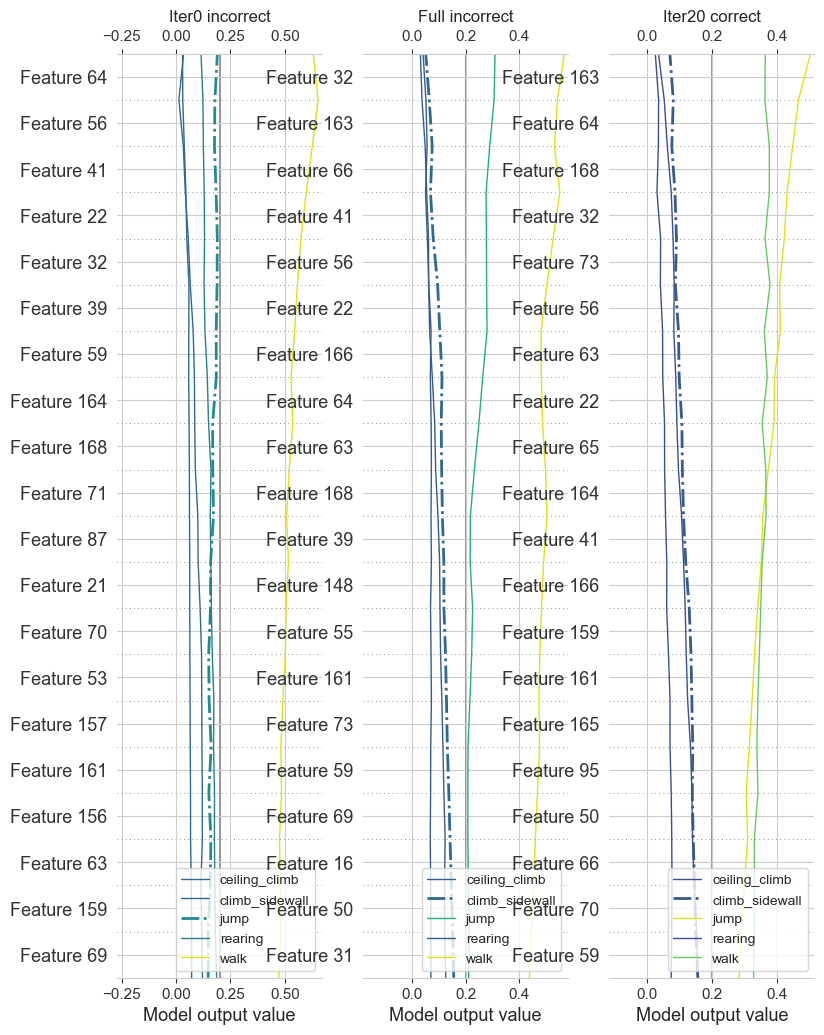

In [33]:
example_num = 5
class_labels = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
row_index = idx_notother[list(improvement_active_idx)[example_num]]
fig = plt.figure()
ax0 = fig.add_subplot(131)
# plt.suptitle('learning')
my_cmap = ListedColormap(sns.color_palette("viridis", 20).as_hex())
iter0_ex_result_atk = shap.multioutput_decision_plot(list(expected_values_iter0),
                               shap_values_iter0,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               highlight=int(targets_test[row_index]),
                               # highlight=0,
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               feature_display_range=slice(-1, -21, -1),
                               plot_color=my_cmap,
                               color_bar=False,
                               return_objects=True
                               )
ax0.set_title('Iter0 incorrect')
top10_iter0_atk = [int(iter0_ex_result_atk.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter0_ex_result_atk.feature_names[::-1][:10]))]

ax1 = fig.add_subplot(132)
unbal_ex_result_atk = shap.multioutput_decision_plot(list(expected_values_unbal),
                               shap_values_unbal,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               # highlight=int(targets_test[row_index]),
                               highlight=1,
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               feature_display_range=slice(-1, -21, -1),
                               plot_color=my_cmap,
                               color_bar=False,
                               return_objects=True
                               )
ax1.set_title('Full incorrect')
top10_unbal_atk = [int(unbal_ex_result_atk.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(unbal_ex_result_atk.feature_names[::-1][:10]))]

ax2 = fig.add_subplot(133)
iter20_ex_result_atk = shap.multioutput_decision_plot(list(expected_values_iter20),
                               shap_values_iter20,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               # highlight=int(targets_test[row_index]),
                               highlight=1,
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               feature_display_range=slice(-1, -21, -1),
                               plot_color=my_cmap,
                               color_bar=False,
                               return_objects=True
                               )
ax2.set_title('Iter20 correct')
top10_iter20_atk = [int(iter20_ex_result_atk.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter20_ex_result_atk.feature_names[::-1][:10]))]

plt.gcf().set_size_inches(9, 12)
plt.show()
# fig.savefig(f'../figures/decision_plot_iter0_unbal_iter20_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

In [34]:
class_labels[int(targets_test[row_index])]

'jump'

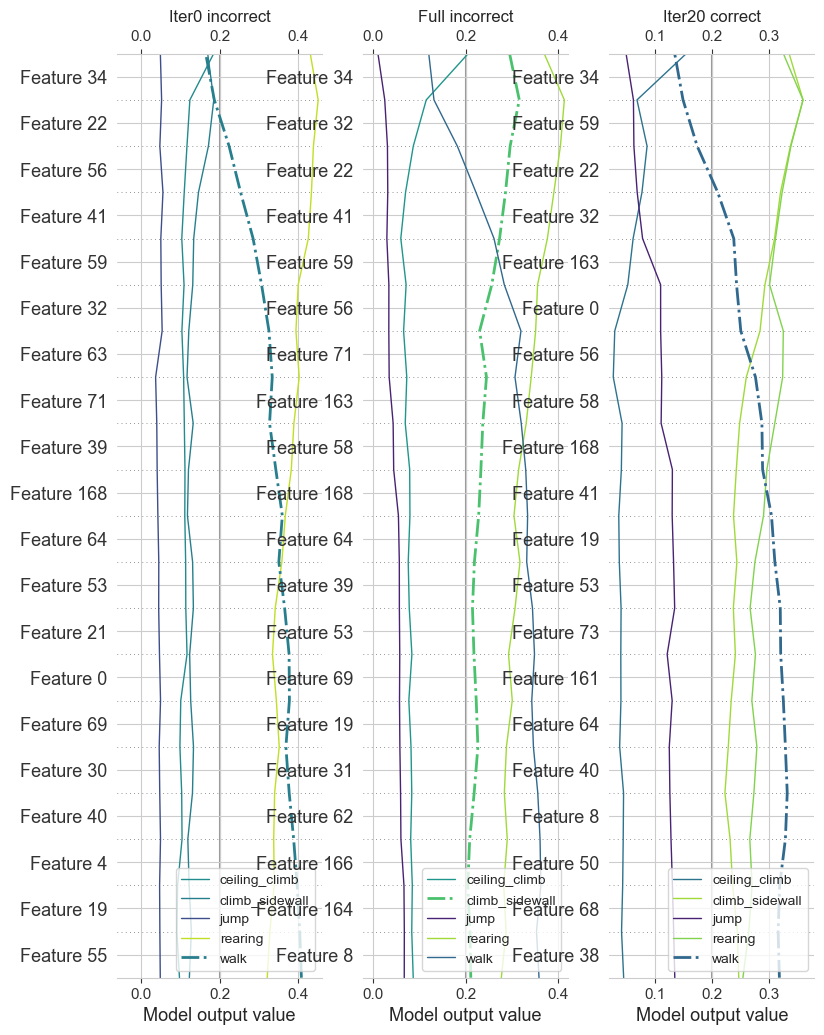

In [38]:
example_num = 1
class_labels = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
row_index = idx_notother[list(improvement_active_idx)[example_num]]
# row_index = idx_notother[1]
fig = plt.figure()
ax0 = fig.add_subplot(131)
# plt.suptitle('learning')
my_cmap = ListedColormap(sns.color_palette("viridis", 20).as_hex())
iter0_ex_result_inv = shap.multioutput_decision_plot(list(expected_values_iter0),
                               shap_values_iter0,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               # highlight=int(targets_test[row_index]),
                               highlight=4,
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               feature_display_range=slice(-1, -21, -1),
                               plot_color=my_cmap,
                               color_bar=False,
                               return_objects=True
                               )
ax0.set_title('Iter0 incorrect')
top10_iter0_inv = [int(iter0_ex_result_inv.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter0_ex_result_inv.feature_names[::-1][:10]))]

ax1 = fig.add_subplot(132)
unbal_ex_result_inv = shap.multioutput_decision_plot(list(expected_values_unbal),
                               shap_values_unbal,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               highlight=int(targets_test[row_index]),
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               feature_display_range=slice(-1, -21, -1),
                               plot_color=my_cmap,
                               color_bar=False,
                               return_objects=True
                               )
ax1.set_title('Full incorrect')
top10_unbal_inv = [int(unbal_ex_result_inv.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(unbal_ex_result_inv.feature_names[::-1][:10]))]

ax2 = fig.add_subplot(133)
iter20_ex_result_inv = shap.multioutput_decision_plot(list(expected_values_iter20),
                               shap_values_iter20,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               # highlight=int(targets_test[row_index]),
                               highlight=4,
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               feature_display_range=slice(-1, -21, -1),
                               plot_color=my_cmap,
                               color_bar=False,
                               return_objects=True
                               )
ax2.set_title('Iter20 correct')
top10_iter20_inv = [int(iter20_ex_result_inv.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter20_ex_result_inv.feature_names[::-1][:10]))]

plt.gcf().set_size_inches(9, 12)
plt.show()
# fig.savefig(f'../figures/decision_plot_iter0_unbal_iter20_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

  0%|          | 0/8 [00:00<?, ?it/s]

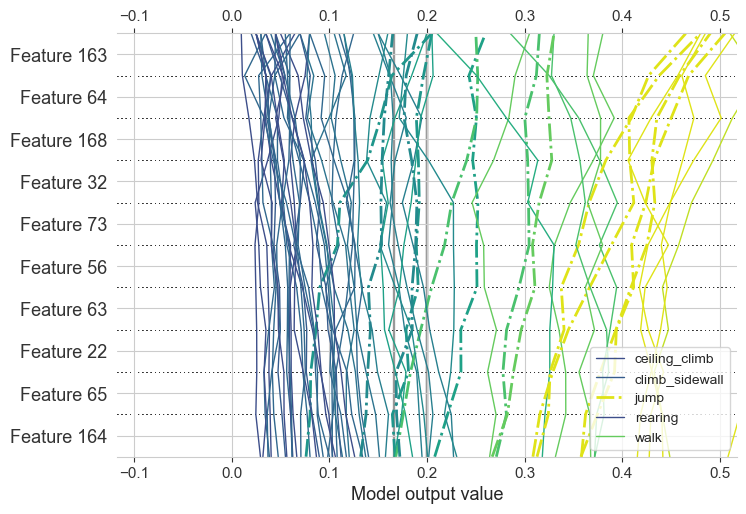

In [127]:
example_nums = np.arange(0, len(list(improvement_active_idx)))
class_labels = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
my_cmap = ListedColormap(sns.color_palette("viridis", 20).as_hex())
iter0_topfeatures_atk = []
unbal_topfeatures_atk = []
iter20_topfeatures_atk = []
for example_num in notebook.tqdm(example_nums):
    row_index = idx_notother[list(improvement_active_idx)[example_num]]
    if int(targets_test[row_index]) == 2:
        iter0_decision_plot_result = shap.multioutput_decision_plot(list(expected_values_iter0),
                                       shap_values_iter0,
                                       row_index=row_index,
                                       # feature_names=heart_feature_names,
                                       highlight=int(targets_test[row_index]),
                                       legend_labels=class_labels,
                                       legend_location='lower right',
                                       show=False,
                                       feature_display_range=slice(-1, -11, -1),
                                       plot_color=my_cmap,
                                       color_bar=False,
                                       return_objects=True,
                                       )
        iter0_topfeatures_atk.append([int(iter0_decision_plot_result.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter0_decision_plot_result.feature_names[::-1][:10]))])
        unbal_decision_plot_result = shap.multioutput_decision_plot(list(expected_values_unbal),
                                       shap_values_unbal,
                                       row_index=row_index,
                                       # feature_names=heart_feature_names,
                                       highlight=int(targets_test[row_index]),
                                       legend_labels=class_labels,
                                       legend_location='lower right',
                                       show=False,
                                       feature_display_range=slice(-1, -11, -1),
                                       plot_color=my_cmap,
                                       color_bar=False,
                                       return_objects=True
                                       )
        unbal_topfeatures_atk.append([int(unbal_decision_plot_result.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(unbal_decision_plot_result.feature_names[::-1][:10]))])
        iter20_decision_plot_result = shap.multioutput_decision_plot(list(expected_values_iter20),
                                       shap_values_iter20,
                                       row_index=row_index,
                                       # feature_names=heart_feature_names,
                                       highlight=int(targets_test[row_index]),
                                       legend_labels=class_labels,
                                       legend_location='lower right',
                                       show=False,
                                       feature_display_range=slice(-1, -11, -1),
                                       plot_color=my_cmap,
                                       color_bar=False,
                                       return_objects=True
                                       )
        iter20_topfeatures_atk.append([int(iter20_decision_plot_result.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter20_decision_plot_result.feature_names[::-1][:10]))])

In [128]:
iter0_bins, iter0_edges = np.histogram(np.hstack(iter0_topfeatures_atk), bins=[0, 78, 156, 169])

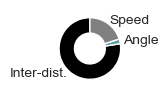

In [129]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = iter0_bins.copy()
pie_colors = ['black', 'cadetblue', 'grey']
pie_labels = ['Inter-dist.', 'Angle', 'Speed']
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
explode = [0, 0, 0]
wedges, texts = ax.pie(sizes,
                       labels=pie_labels,
                       explode=explode,
                       colors=pie_colors,
                       wedgeprops=dict(width=0.5),
                       startangle=90)

# ax.set_title("Top 5 impactful")

plt.show()
# fig.savefig('../figures/iter0_top10_impactful_decisions_jump_3dmonkey_1.svg', dpi=600)

In [130]:
unbal_bins, unbal_edges = np.histogram(np.hstack(unbal_topfeatures_atk), bins=[0, 78, 156, 169])

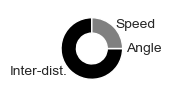

In [131]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = unbal_bins.copy()
pie_colors = ['black', 'cadetblue', 'grey']
pie_labels = ['Inter-dist.', 'Angle', 'Speed']
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
explode = [0, 0, 0]
wedges, texts = ax.pie(sizes,
                       labels=pie_labels,
                       explode=explode,
                       colors=pie_colors,
                       wedgeprops=dict(width=0.5),
                       startangle=90)

# ax.set_title("Top 5 impactful")

plt.show()
# fig.savefig('../figures/unbal_top10_impactful_decisions_jump_3dmonkey_1.svg', dpi=600)

In [132]:
iter20_bins, iter20_edges = np.histogram(np.hstack(iter20_topfeatures_atk), bins=[0, 78, 156, 169])

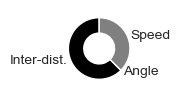

In [133]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = iter20_bins.copy()
pie_colors = ['black', 'cadetblue', 'grey']
pie_labels = ['Inter-dist.', 'Angle', 'Speed']
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
explode = [0, 0, 0]
wedges, texts = ax.pie(sizes,
                       labels=pie_labels,
                       explode=explode,
                       colors=pie_colors,
                       wedgeprops=dict(width=0.5),
                       startangle=90)

# ax.set_title("Top 5 impactful")

plt.show()
# fig.savefig('../figures/iter20_top10_impactful_decisions_jump_3dmonkey_1.svg', dpi=600)

In [187]:
idx_notother[-1]

21829

  0%|          | 0/8 [00:00<?, ?it/s]

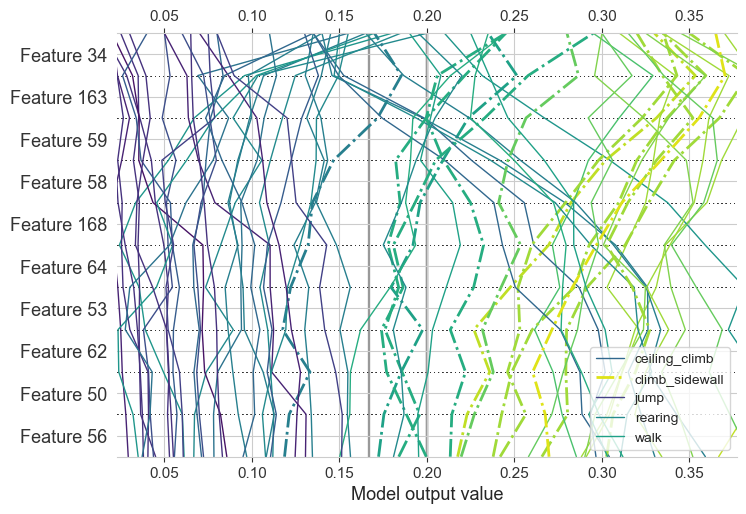

In [96]:
example_nums = np.arange(0, len(list(improvement_active_idx)))
class_labels = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
my_cmap = ListedColormap(sns.color_palette("viridis", 20).as_hex())
iter0_topfeatures_inv = []
unbal_topfeatures_inv = []
iter20_topfeatures_inv = []
for example_num in notebook.tqdm(example_nums):
    row_index = idx_notother[list(improvement_active_idx)[example_num]]
    if int(targets_test[row_index]) == 1:
        iter0_decision_plot_result = shap.multioutput_decision_plot(list(expected_values_iter0),
                                       shap_values_iter0,
                                       row_index=row_index,
                                       # feature_names=heart_feature_names,
                                       highlight=int(targets_test[row_index]),
                                       legend_labels=class_labels,
                                       legend_location='lower right',
                                       show=False,
                                       feature_display_range=slice(-1, -11, -1),
                                       plot_color=my_cmap,
                                       color_bar=False,
                                       return_objects=True,
                                       )
        iter0_topfeatures_inv.append([int(iter0_decision_plot_result.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter0_decision_plot_result.feature_names[::-1][:10]))])
        unbal_decision_plot_result = shap.multioutput_decision_plot(list(expected_values_unbal),
                                       shap_values_unbal,
                                       row_index=row_index,
                                       # feature_names=heart_feature_names,
                                       highlight=int(targets_test[row_index]),
                                       legend_labels=class_labels,
                                       legend_location='lower right',
                                       show=False,
                                       feature_display_range=slice(-1, -11, -1),
                                       plot_color=my_cmap,
                                       color_bar=False,
                                       return_objects=True
                                       )
        unbal_topfeatures_inv.append([int(unbal_decision_plot_result.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(unbal_decision_plot_result.feature_names[::-1][:10]))])
        iter20_decision_plot_result = shap.multioutput_decision_plot(list(expected_values_iter20),
                                       shap_values_iter20,
                                       row_index=row_index,
                                       # feature_names=heart_feature_names,
                                       highlight=int(targets_test[row_index]),
                                       legend_labels=class_labels,
                                       legend_location='lower right',
                                       show=False,
                                       feature_display_range=slice(-1, -11, -1),
                                       plot_color=my_cmap,
                                       color_bar=False,
                                       return_objects=True
                                       )
        iter20_topfeatures_inv.append([int(iter20_decision_plot_result.feature_names[::-1][:10][j].rpartition('Feature ')[2]) for j in range(len(iter20_decision_plot_result.feature_names[::-1][:10]))])

In [98]:
iter0_bins, iter0_edges = np.histogram(np.hstack(iter0_topfeatures_inv), bins=[0, 78, 156, 169])

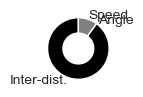

In [99]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = iter0_bins.copy()
pie_colors = ['black', 'cadetblue', 'grey']
pie_labels = ['Inter-dist.', 'Angle', 'Speed']
explode = [0, 0, 0]
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
wedges, texts = ax.pie(sizes,
                       labels=pie_labels,
                       explode=explode,
                       colors=pie_colors,
                       wedgeprops=dict(width=0.5),
                       startangle=90,
                       )

# ax.set_title("Top 5 impactful")

plt.show()
fig.savefig('../figures/iter0_top10_impactful_decisions_climbS_3dmonkey_1.svg', dpi=600)

In [100]:
unbal_bins, unbal_edges = np.histogram(np.hstack(unbal_topfeatures_inv), bins=[0, 78, 156, 169])

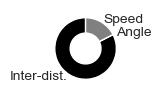

In [101]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = unbal_bins.copy()
pie_colors = ['black', 'cadetblue', 'grey']
pie_labels = ['Inter-dist.', 'Angle', 'Speed']
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
explode = [0, 0, 0]
wedges, texts = ax.pie(sizes,
                       labels=pie_labels,
                       explode=explode,
                       colors=pie_colors,
                       wedgeprops=dict(width=0.5),
                       startangle=90)

# ax.set_title("Top 5 impactful")

plt.show()
fig.savefig('../figures/unbal_top10_impactful_decisions_climbS_3dmonkey_1.svg', dpi=600)

In [102]:
iter20_bins, iter20_edges = np.histogram(np.hstack(iter20_topfeatures_inv), bins=[0, 78, 156, 169])

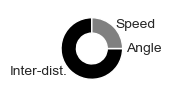

In [103]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = iter20_bins.copy()
pie_colors = ['black', 'cadetblue', 'grey']
pie_labels = ['Inter-dist.', 'Angle', 'Speed']
explode = [0, 0, 0]
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
wedges, texts = ax.pie(sizes,
                       labels=pie_labels,
                       explode=explode,
                       colors=pie_colors,
                       wedgeprops=dict(width=0.5),
                       startangle=90,
                       )

# ax.set_title("Top 5 impactful")

plt.show()
fig.savefig('../figures/iter20_top10_impactful_decisions_climbS_3dmonkey_1.svg', dpi=600)

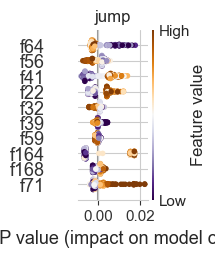

In [138]:
behaviors = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
fig = plt.figure()

ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack(shap_values_iter0[2][:, np.array(top10_iter0_atk)]),
                  np.vstack(binned_scaled_test_features[0][:, np.array(top10_iter0_atk)]),
                  # plot_type='violin',
                  # class_inds=np.arange(10, 0, -1),
                  feature_names=[f'f{i}' for i in np.array(top10_iter0_atk)],
                  max_display=10, show=False, sort=False,
                  cmap='PuOr_r')
ax1.set_title(behaviors[2])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_iter0_decision_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

In [137]:
class_labels[int(targets_test[row_index])]

'jump'

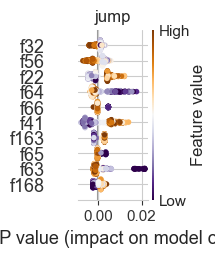

In [139]:
behaviors = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
fig = plt.figure()

ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack(shap_values_iter0[2][:, np.array(top10_unbal_atk)]),
                  np.vstack(binned_scaled_test_features[0][:, np.array(top10_unbal_atk)]),
                  # plot_type='violin',
                  # class_inds=np.arange(10, 0, -1),
                  feature_names=[f'f{i}' for i in np.array(top10_unbal_atk)],
                  max_display=10, show=False, sort=False,
                  cmap='PuOr_r')
ax1.set_title(behaviors[2])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_unbal_decision_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

In [118]:
np.where(targets_test == 2)[0], shap_values_iter20[2].shape

(array([ 39,  40,  41,  42,  43, 153, 154, 155, 156]), (306, 169))

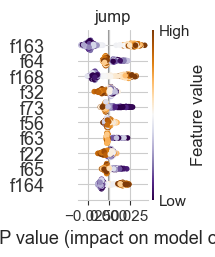

In [140]:
behaviors = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
fig = plt.figure()
ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack(shap_values_iter20[2][:, np.array(top10_iter20_atk)]),
                  np.vstack(binned_scaled_test_features[0][:, np.array(top10_iter20_atk)]),
                  feature_names=[f'f{i}' for i in np.array(top10_iter20_atk)],
                  max_display=10, show=False, sort=False,
                  cmap='PuOr_r')
ax1.set_title(behaviors[2])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_iter20_decision_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

### investigation shap values

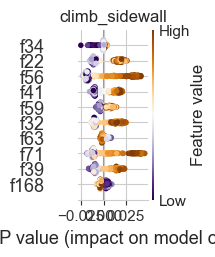

In [142]:
behaviors = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
fig = plt.figure()

ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack(shap_values_iter0[1][:, np.array(top10_iter0_inv)]),
                  np.vstack(binned_scaled_test_features[0][:, np.array(top10_iter0_inv)]),
                  # plot_type='violin',
                  # class_inds=np.arange(10, 0, -1),
                  feature_names=[f'f{i}' for i in np.array(top10_iter0_inv)],
                  max_display=10, show=False, sort=False,
                  cmap='PuOr_r')
ax1.set_title(behaviors[1])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_iter0_decision_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

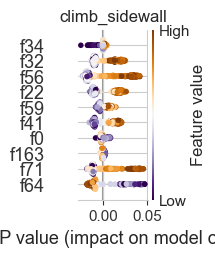

In [144]:
behaviors = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
fig = plt.figure()

ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack(shap_values_iter0[1][:, np.array(top10_unbal_inv)]),
                  np.vstack(binned_scaled_test_features[0][:, np.array(top10_unbal_inv)]),
                  # plot_type='violin',
                  # class_inds=np.arange(10, 0, -1),
                  feature_names=[f'f{i}' for i in np.array(top10_unbal_inv)],
                  max_display=10, show=False, sort=False,
                  cmap='PuOr_r')
ax1.set_title(behaviors[1])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_unbal_decision_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

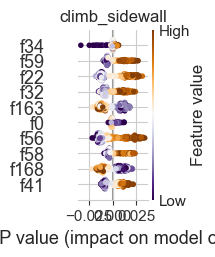

In [145]:
behaviors = ['ceiling_climb', 'climb_sidewall', 'jump', 'rearing', 'walk']
fig = plt.figure()
ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack(shap_values_iter20[1][:, np.array(top10_iter20_inv)]),
                  np.vstack(binned_scaled_test_features[0][:, np.array(top10_iter20_inv)]),
                  feature_names=[f'f{i}' for i in np.array(top10_iter20_inv)],
                  max_display=10, show=False, sort=False,
                  cmap='PuOr_r')
ax1.set_title(behaviors[1])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_iter20_decision_{class_labels[int(targets_test[row_index])]}_3dmonkey.svg', dpi=600)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


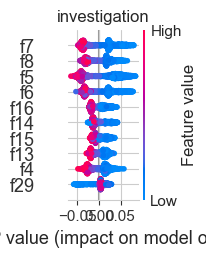

In [134]:
behaviors = ['attack', 'investigation', 'mount']
fig = plt.figure()

ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack([shap_values_unbal[1][i, np.array(top10_unbal)] for i in list(active_diff_idx)]),
                  np.vstack([test_scaled_features[i, np.array(top10_unbal)] for i in list(active_diff_idx)]),
                  # plot_type='violin',
                  # class_inds=np.arange(10, 0, -1),
                  feature_names=[f'f{i}' for i in np.array(top10_unbal)],
                  max_display=10, show=False, sort=False)
ax1.set_title(behaviors[1])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_unbal_decision_{class_labels[int(targets_test[row_index])]}.svg', dpi=600)

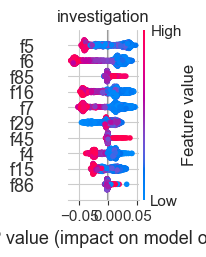

In [132]:
behaviors = ['attack', 'investigation', 'mount']
fig = plt.figure()
ax1 = fig.add_subplot(111)
shap.summary_plot(np.vstack([shap_values_iter20[1][i, np.array(top10_active)] for i in list(active_diff_idx)]),
                  np.vstack([test_scaled_features[i, np.array(top10_active)] for i in list(active_diff_idx)]),
                  feature_names=[f'f{i}' for i in np.array(top10_active)],
                  max_display=10, show=False, sort=False)
ax1.set_title(behaviors[1])

plt.gcf().set_size_inches(1, 2)
plt.show()
fig.savefig(f'../figures/summary_plot_active_decision_{class_labels[int(targets_test[row_index])]}.svg', dpi=600)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


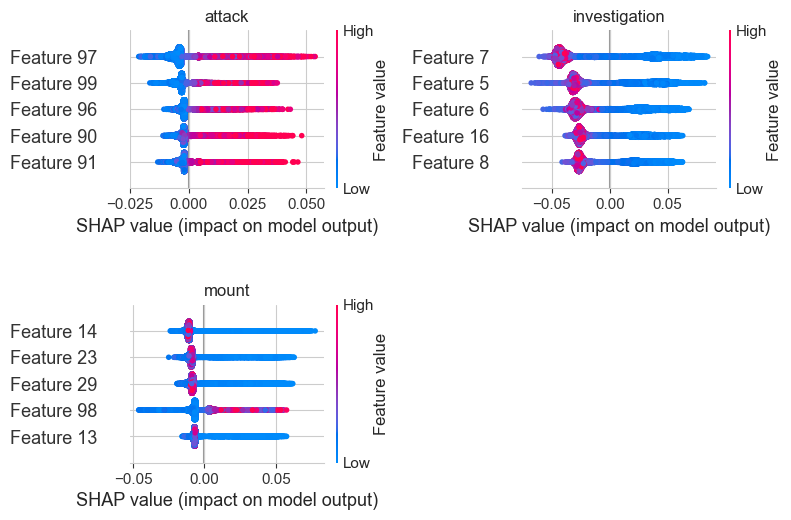

In [353]:
behaviors = ['attack', 'investigation', 'mount']
fig = plt.figure()
ax0 = fig.add_subplot(221)
shap.summary_plot(shap_values_iter0[0], test_scaled_features,
                  max_display=5, show=False)
ax0.set_title(behaviors[0])

ax1 = fig.add_subplot(222)
shap.summary_plot(shap_values_iter0[1], test_scaled_features,
                  max_display=5, show=False)
ax1.set_title(behaviors[1])

ax2 = fig.add_subplot(223)
shap.summary_plot(shap_values_iter0[2], test_scaled_features,
                  max_display=5, show=False)
ax2.set_title(behaviors[2])


plt.gcf().set_size_inches(8, 6)
plt.show()

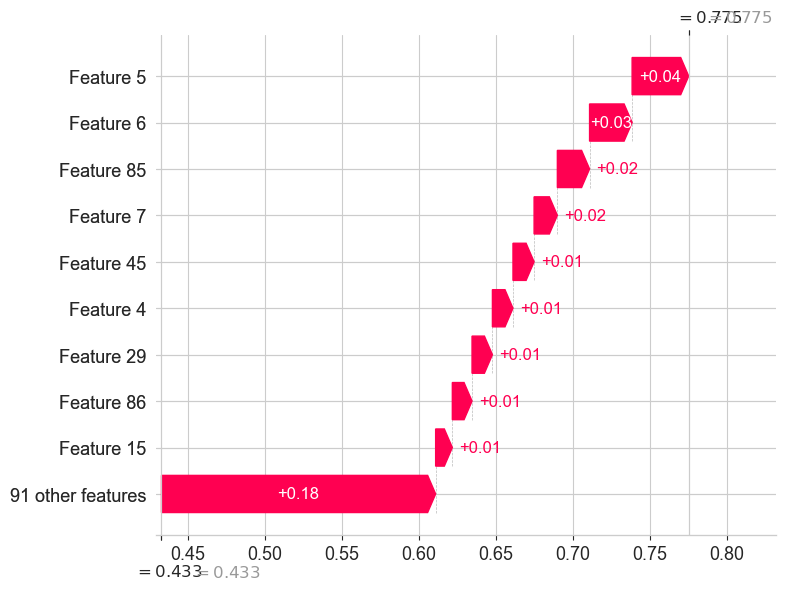

In [372]:
# shap.initjs()
row_index = 2146
shap.plots._waterfall.waterfall_legacy(expected_values_iter20[1], shap_values_iter20[1][row_index])

In [24]:
shap_interaction_values = shap.TreeExplainer(active_models[0]).shap_interaction_values(test_scaled_features[:50,:])

In [26]:
inds

array([ 5, 29, 15, 28, 94])

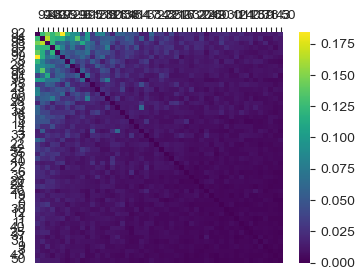

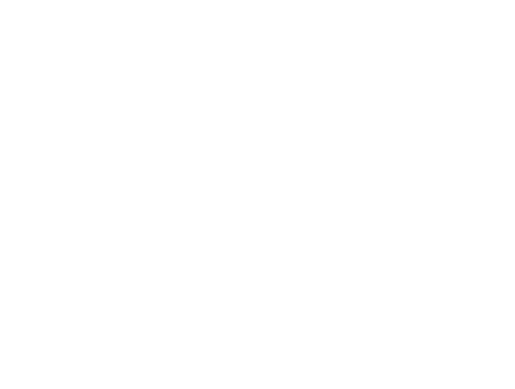

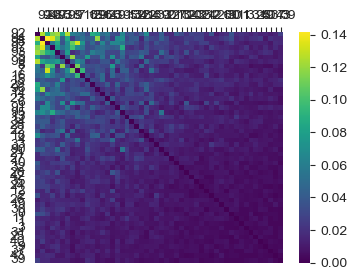

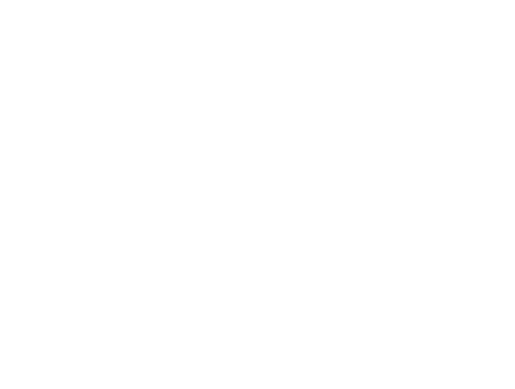

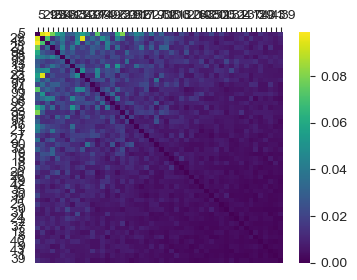

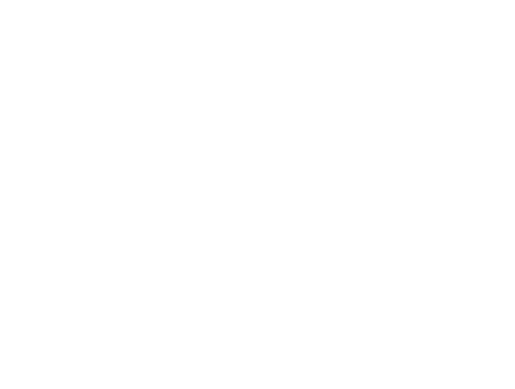

In [29]:
for class_selected in np.arange(3):
    tmp = np.abs(shap_interaction_values[class_selected]).sum(0)
    for i in range(tmp.shape[0]):
        tmp[i,i] = 0
    inds = np.argsort(-tmp.sum(0))[:50]
    tmp2 = tmp[inds,:][:,inds]
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    sns.heatmap(tmp2, cmap='viridis', ax=ax)
    ax.set_yticks(np.arange(0.5, tmp2.shape[0]+.5), inds, rotation=0, horizontalalignment="right")
    ax.set_xticks(np.arange(0.5, tmp2.shape[0]+.5), inds, rotation=0, horizontalalignment="left")
    plt.gca().xaxis.tick_top()
    plt.show()
    plt.axis('off')

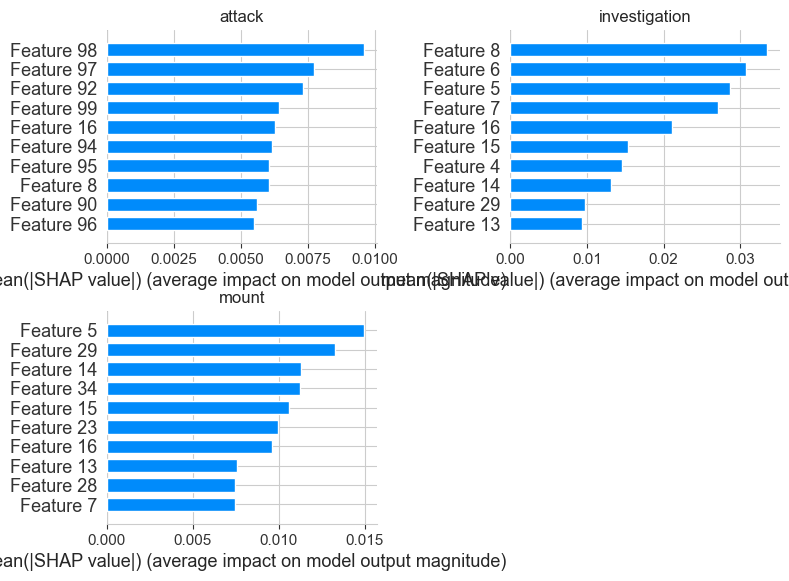

In [360]:
behaviors = ['attack', 'investigation', 'mount']
fig = plt.figure()
ax0 = fig.add_subplot(221)
shap.summary_plot(shap_values_iter20[0], test_scaled_features,
                  max_display=10, show=False, plot_type="bar")
ax0.set_title(behaviors[0])

ax1 = fig.add_subplot(222)
shap.summary_plot(shap_values_iter20[1], test_scaled_features,
                  max_display=10, show=False, plot_type="bar")
ax1.set_title(behaviors[1])

ax2 = fig.add_subplot(223)
shap.summary_plot(shap_values_iter20[2], test_scaled_features,
                  max_display=10, show=False, plot_type="bar")
ax2.set_title(behaviors[2])


plt.gcf().set_size_inches(8, 6)
plt.show()

In [351]:
shap_values_unbal[0].shape, unbal_feats[0].shape

((21830, 100), (42275, 100))

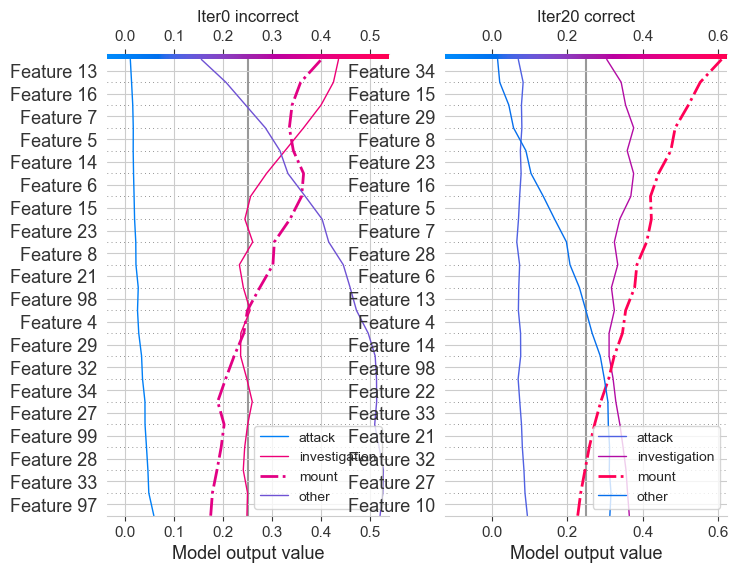

In [99]:
example_num = 100
class_labels = ['attack', 'investigation', 'mount', 'other']
row_index = idx_notother[list(improvement_idx)[example_num]]
fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.multioutput_decision_plot(list(expected_values_iter0),
                               shap_values_iter0,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               highlight=int(targets_test[row_index]),
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               )
ax0.set_title('Iter0 incorrect')

ax1 = fig.add_subplot(122)
shap.multioutput_decision_plot(list(expected_values_iter20),
                               shap_values_iter20,
                               row_index=row_index,
                               # feature_names=heart_feature_names,
                               highlight=int(targets_test[row_index]),
                               legend_labels=class_labels,
                               legend_location='lower right',
                               show=False,
                               )
ax1.set_title('Iter20 correct')


plt.gcf().set_size_inches(8, 6)
plt.show()